In [1]:
import sys
import os
from itertools import cycle
from time import time

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader

from sklearn.linear_model import LassoLars
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import OrthogonalMatchingPursuit

sys.path.append(os.pardir)
sys.path.append(os.path.join(os.pardir, os.pardir))
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

from src.dataset.dataloaders import get_dataset
from src.dataset.torch_dataset import PatchAndFlatenDataset, NormalizationType
#from src.dictionary.basic_dictionary_learning import base_algo1, batched_algo1, test_algo2_similarities
from src.dictionary.dictionary_algo import DictionaryAlgoBasic, DictionaryAlgoParallel


In [2]:
patch_size=(16, 16)
patches_per_image=5
batch_size=16

test_dir = os.path.join(notebook_dir, "../dataset/data/berkeley/test/")

test_dataset = PatchAndFlatenDataset(
    directory=test_dir, patch_size=patch_size, patches_per_image=patches_per_image, norm_type=NormalizationType.ZSCORE
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
train_loader, _, _ = get_dataset("berkeley",  patch_size=(16, 16), patches_per_image=5, batch_size=batch_size, norm_type=NormalizationType.ZSCORE)

for p in train_loader:
    print(p.shape)  # [bs, c*h*w]
    break
for p in test_loader:
    print(p[0].shape)  # [bs, c, h, w]
    print(p[1].shape)  # [bs, c*h*w]
    break

torch.Size([16, 768])
torch.Size([16, 3, 16, 16])
torch.Size([16, 768])


# Base pipeline

## View data

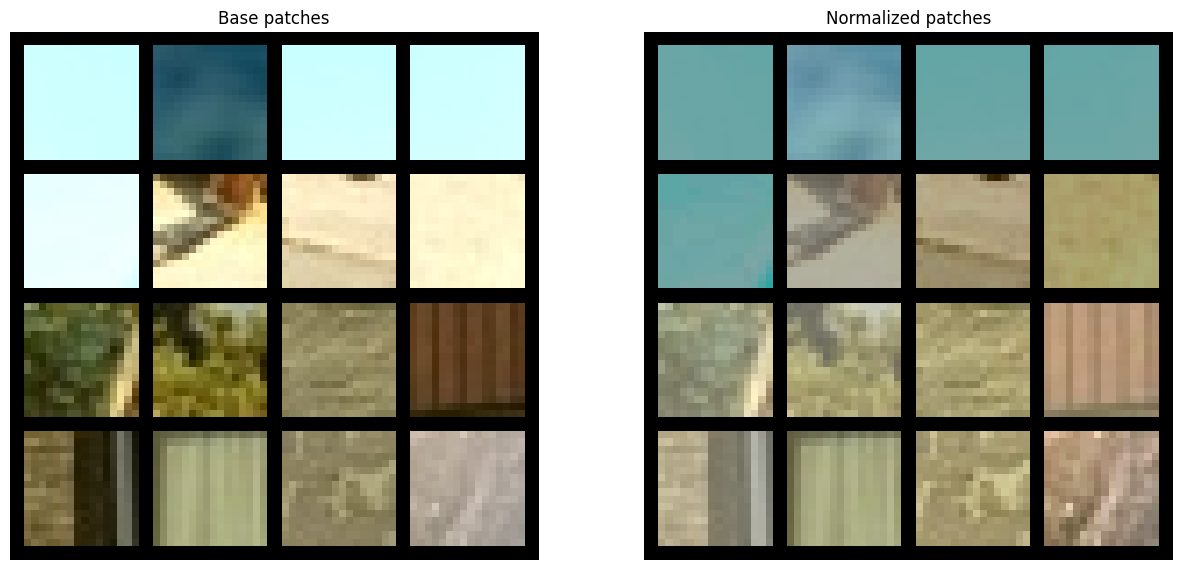

In [4]:
def plot_patches_and_flattens(patches, flattens, patch_size, nrow=4):
    c = 3
    p_h, p_w = patch_size

    flattens_reshaped = flattens.view(-1, c, p_h, p_w)

    grid_flatten = make_grid(flattens_reshaped[:nrow * nrow], nrow=nrow, normalize=True)
    grid_np_fl = grid_flatten.permute(1, 2, 0).cpu().numpy()


    grid = make_grid(patches[:nrow*nrow], nrow=nrow, normalize=True, value_range=(0, 1))
    grid_np_base = grid.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    ax[0].imshow(grid_np_base)
    ax[0].set_title("Base patches")
    ax[0].axis('off')

    ax[1].imshow(grid_np_fl)
    ax[1].set_title("Normalized patches")
    ax[1].axis('off')

    plt.show()

for p, f in test_loader:
    plot_patches_and_flattens(p, f, patch_size=(16, 16), nrow=4)
    break


## Train

In [5]:
from tqdm import tqdm
class FiniteGenerator:
    def __init__(self, iterable, nb_elt):
        self.iterable = iterable
        self.nb_elt = nb_elt
    def __len__(self):
        return self.nb_elt
    def __iter__(self):
        infinite_loader = cycle(self.iterable)
        
        for k in tqdm(range(self.nb_elt)):
            yield next(infinite_loader)

In [6]:
infinite_x_loader = cycle(train_loader)
generator = FiniteGenerator(infinite_x_loader, int(1e4))
m = 16*16*3
DictLearner = DictionaryAlgoParallel(m=m, k=200, lbd=1.2/(m*np.sqrt(m)), dic_update_steps=100, use_cuda=False, dico_update="quick_update_cv_check", n_jobs=-1)
DictLearner.fit(generator)


100%|██████████| 10000/10000 [11:03<00:00, 15.08it/s]


## Util

In [12]:
def visualize_reconstruction(D, loader, l1_penalty, n_nonzero_coefs=10, omp=False):
    for _ in range(3):
        # Fetch a batch of data from the loader
        patch_x, flatten_x = next(loader)
        patch_x, flatten_x = patch_x[0], flatten_x[0]

        # Compute mean and std for patch_x
        mean = flatten_x.mean()
        std = flatten_x.std()

        std = std.item() if isinstance(std, torch.Tensor) else std
        mean = mean.item() if isinstance(mean, torch.Tensor) else mean

        # Normalize flatten_x based on mean and std
        if std > 0:
            normalized_x = (flatten_x - mean) / std
        else:
            normalized_x = flatten_x.clone()

        # Solve the sparse coding problem
        if omp:
            omp_solver = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs, fit_intercept=False)
            omp_solver.fit(X=D, y=normalized_x)
            alpha = torch.tensor(omp_solver.coef_, dtype=torch.float32)
        else:
            lasso = LassoLars(alpha=l1_penalty, fit_intercept=False)
            lasso.fit(X=D, y=normalized_x)
            alpha = torch.tensor(lasso.coef_, dtype=torch.float32)

        # Reconstruct the signal
        x_reconstructed_scaled = torch.matmul(torch.tensor(D), alpha).numpy()
        x_reconstructed = (x_reconstructed_scaled * std + mean)  # De-normalize

        # Reshape and permute for visualization
        original_x = patch_x.permute(1, 2, 0)  # [H, W, C] from [C, H, W]
        scaled_x = normalized_x.reshape(3, 16, 16).permute(1, 2, 0)  # [H, W, C]
        # reconstructed_x = x_reconstructed.reshape(3, 16, 16).permute(1, 2, 0)  # [H, W, C]
        reconstructed_x = torch.tensor(x_reconstructed).reshape(3, 16, 16).permute(1, 2, 0)  # [H, W, C]

        # Scale the pixel values for visualization
        original_rgb = (original_x - torch.min(original_x)) / (torch.max(original_x) - torch.min(original_x))
        scaled_rgb = (scaled_x - torch.min(scaled_x)) / (torch.max(scaled_x) - torch.min(scaled_x))
        reconstructed_rgb = (reconstructed_x - torch.min(reconstructed_x)) / (torch.max(reconstructed_x) - torch.min(reconstructed_x))

        # Plot the results
        plt.figure(figsize=(16, 8))

        plt.subplot(2, 3, 1)
        plt.imshow(original_rgb)
        plt.title("Original X (RGB)")
        plt.axis("off")

        plt.subplot(2, 3, 2)
        plt.imshow(scaled_rgb)
        plt.title("Scaled X (RGB)")
        plt.axis("off")

        plt.subplot(2, 3, 3)
        plt.imshow(reconstructed_rgb)
        plt.title("Reconstructed X (RGB)")
        plt.axis("off")

        plt.subplot(2, 1, 2)
        plt.bar(np.arange(len(alpha)), alpha.numpy())
        plt.title("Alpha Activations")
        plt.xlabel("Dictionary Index")
        plt.ylabel("Activation Magnitude")
        plt.tight_layout()

        plt.show()


## Reconstruction

### Test Dataset

In [13]:
l1_penalty = 1.2/(m*np.sqrt(m))
l1_penalty

np.float64(5.638186222554939e-05)

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_85072/3469195411.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed_scaled = torch.matmul(torch.tensor(D), alpha).numpy()


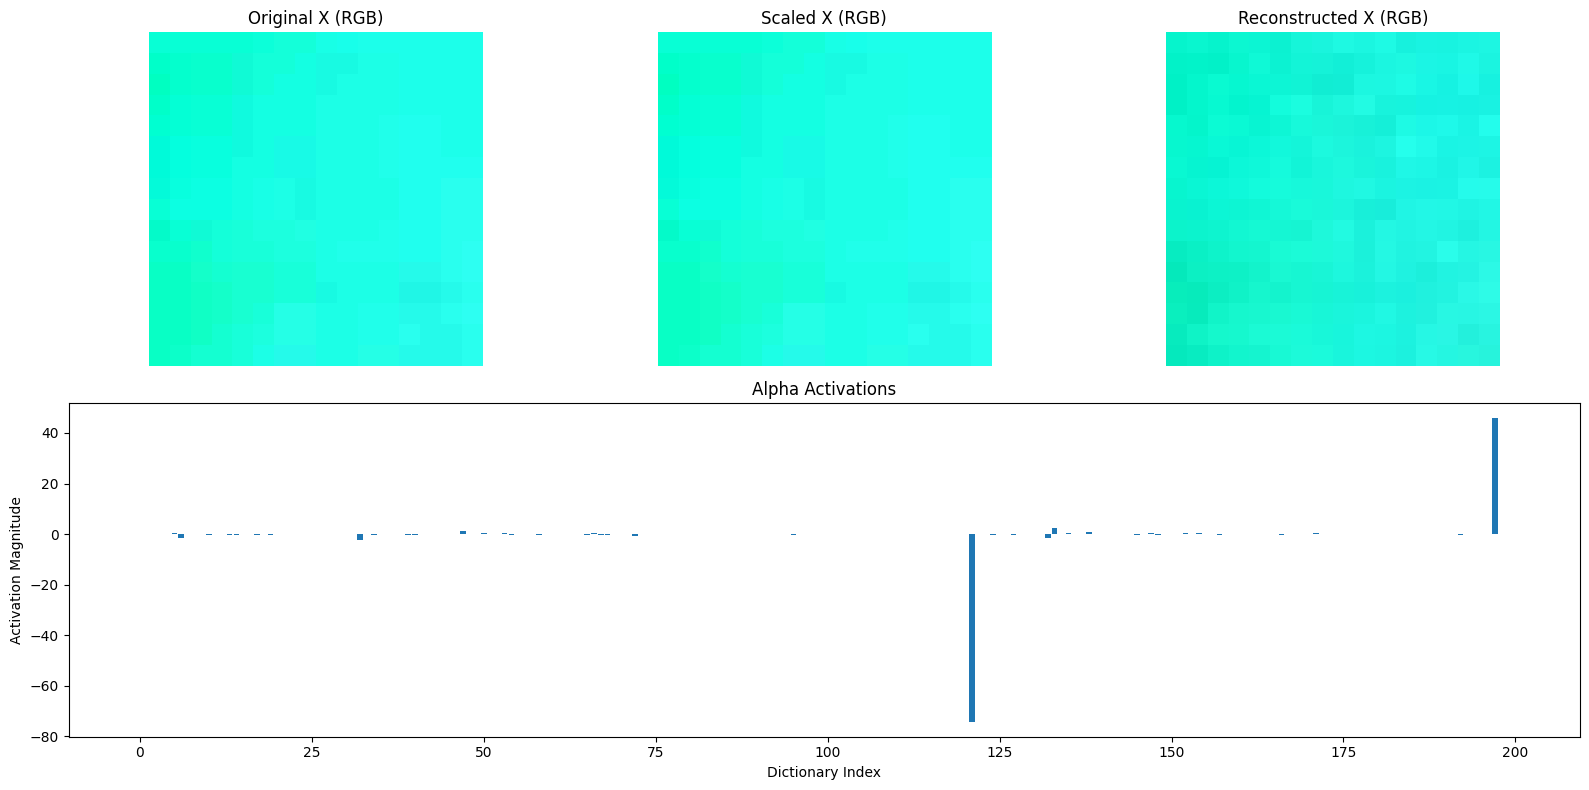

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_85072/3469195411.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed_scaled = torch.matmul(torch.tensor(D), alpha).numpy()


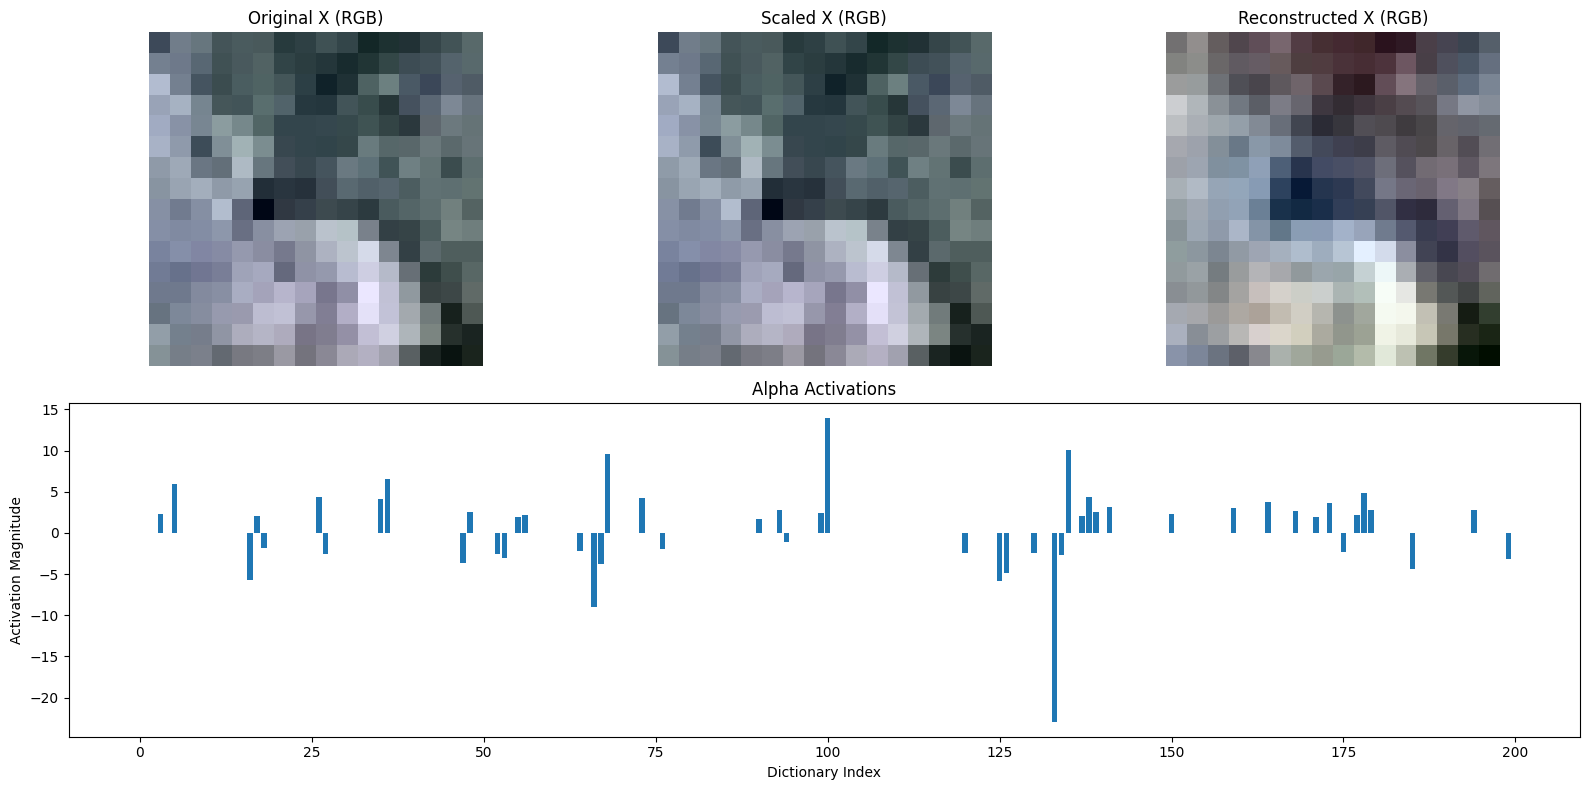

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_85072/3469195411.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed_scaled = torch.matmul(torch.tensor(D), alpha).numpy()


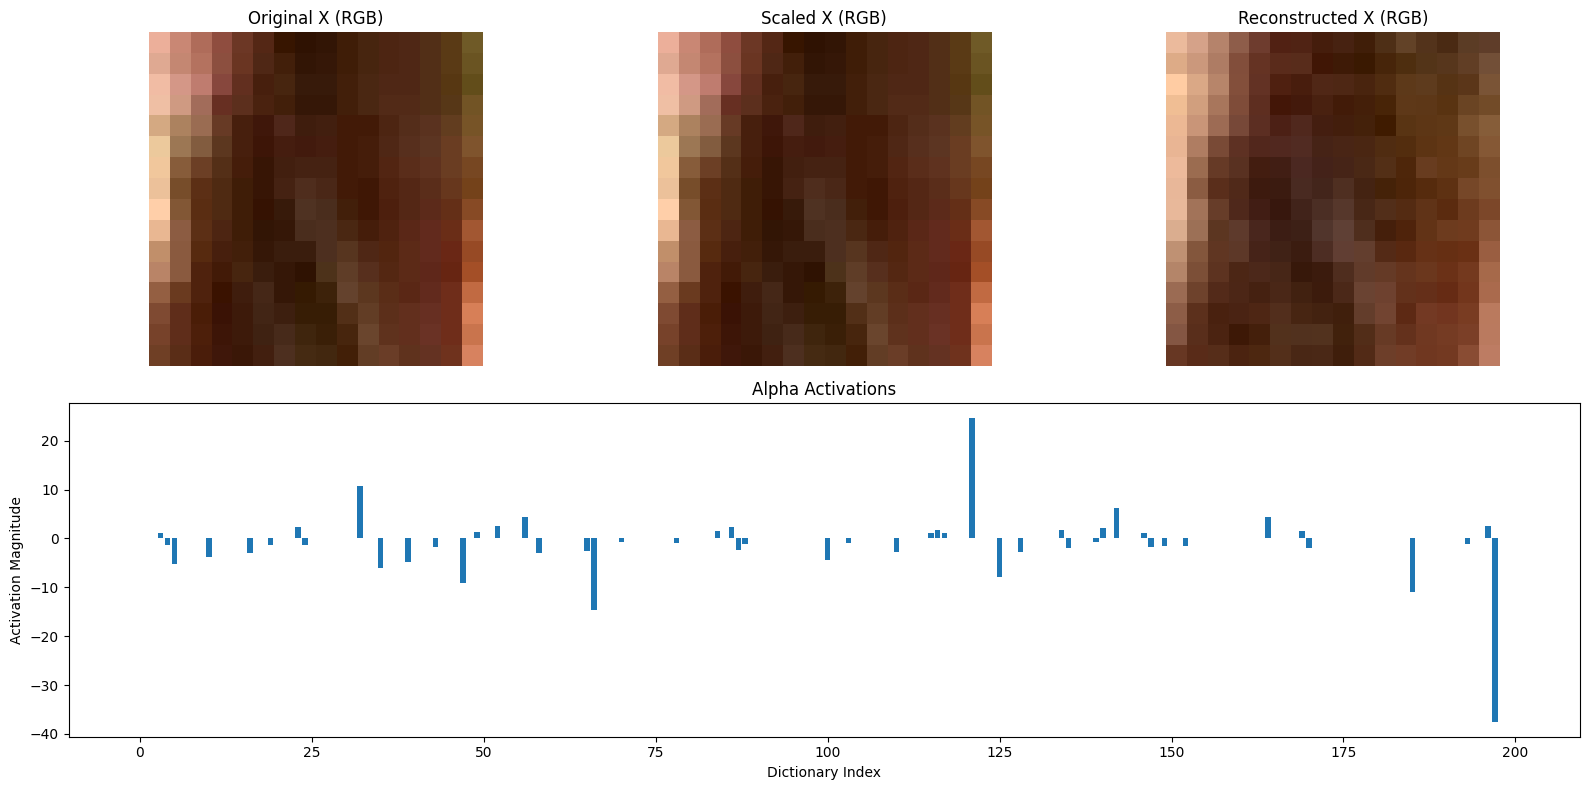

In [15]:
visualize_reconstruction(DictLearner.D, cycle(test_loader), l1_penalty, omp=True, n_nonzero_coefs=50)